# SLEAP Distance Calculation

Brief 1-2 sentence description of notebook.

In [1]:
#calling it a second time may prevent some graphics errors
import matplotlib.pyplot as plt

In [2]:
import os
import glob
import git
import sys


In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib as mpl
# import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


In [4]:
import cv2 
import os 

In [5]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [6]:
git_root

'/nancy/user/riwata/projects/reward_comp_ext'

In [7]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [8]:
import utilities.helper
import sleap.process_pose

In [9]:
from pathlib import Path
import imageio
# import hdbscan

In [10]:
import os 
import cv2  
from PIL import Image  

In [11]:
# sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

# Feature columns

In [12]:
# # based on each subjects individually
# features_columns = ['subject_thorax_velocity', 'agent_thorax_velocity',
#        'subject_thorax_to_agent_thorax', 'subject_nose_to_reward_port',
#        'agent_nose_to_reward_port', 'subject_to_reward_port_angle',
#        'agent_to_reward_port_angle']

In [13]:
frame_difference = 1

In [14]:
smoothing_window = 5

In [15]:
features_columns = ['frame_index',
                    ## Distance metrics
                    'subject_thorax_to_agent_thorax',
                    'nose_to_reward_port_sum',
                    'nose_to_reward_port_diff',
                    ## Velocity and speed metrics
                    'thorax_velocity_sum', 
                    'thorax_velocity_diff',
                    ## Orientation and angle
                    'to_reward_port_angle_sum',
                    'to_reward_port_angle_diff', 
                    # Individual features
                    'subject_nose_to_reward_port',
                    'subject_thorax_velocity',
                    'subject_to_reward_port_angle',
                    'agent_nose_to_reward_port',
                    'agent_thorax_velocity',
                    'agent_to_reward_port_angle',
                    ]

In [16]:
features_columns = ['frame_index',
                    ## Distance metrics
                    'subject_thorax_to_agent_thorax',
                    'nose_to_reward_port_sum',
                    'nose_to_reward_port_diff',
                    'nose_to_tail_sum',
                    'nose_to_tail_diff',
                    ## Velocity and speed metrics
                    'thorax_velocity_sum', 
                    'thorax_velocity_diff',
                    ## Orientation and angle
                    'to_reward_port_angle_sum',
                    'to_reward_port_angle_diff', 
                    # Individual features
                    'subject_nose_to_reward_port',
                    'subject_thorax_velocity',
                    'subject_to_reward_port_angle',
                    'agent_nose_to_reward_port',
                    'agent_thorax_velocity',
                    'agent_to_reward_port_angle',
                    ]

In [17]:
# important_features_columns = ['subject_nose_to_reward_port', 'agent_nose_to_reward_port']
# important_features_columns = ["nose_to_reward_port_sum", "nose_to_reward_port_diff", "subject_thorax_to_agent_thorax"]
important_features_columns =[
## Distance metrics
                    'subject_thorax_to_agent_thorax',
                    'nose_to_reward_port_sum',
                    'nose_to_reward_port_diff',
                    ## Velocity and speed metrics
                    'thorax_velocity_sum', 
                    'thorax_velocity_diff',
                    ## Orientation and angle
                    'to_reward_port_angle_sum',
                    'to_reward_port_angle_diff',]

scaler = 2

# Functions

In [18]:
from scipy.interpolate import interp1d


def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [19]:
def interpolate_nans_in_1d_arr(arr):
    """
    """
    copy_arr = arr.copy()
    nans, x= nan_helper(copy_arr)
    copy_arr[nans] = np.interp(x(nans), x(~nans), copy_arr[~nans])
    return copy_arr

In [20]:
def bools_to_int(row):
    # Convert boolean to integer, then to string, and join to form a binary number string
    binary_string = ''.join(row.astype(int).astype(str))
    # Convert binary string to a decimal integer
    return int(binary_string, 2)

In [21]:
def calculate_angles_from_arrays(A, B, C, D):
    """
    Calculate the angles between vectors AB and CD for arrays of 2D points.

    Parameters:
    - A, B, C, D: Each is a 2D numpy array where each row represents a point in 2D space.
                  A and B represent points defining the first vector, AB, and C and D represent points defining the second vector, CD.

    Returns:
    - A numpy array of angles in degrees between the vectors AB and CD for each set of points.
    """
    # Ensure input arrays are numpy arrays
    A, B, C, D = map(np.array, [A, B, C, D])

    # Calculate vectors AB and CD
    AB = B - A
    CD = D - C

    # Calculate dot products and magnitudes for each pair of vectors
    dot_products = np.einsum('ij,ij->i', AB, CD)
    norms_AB = np.linalg.norm(AB, axis=1)
    norms_CD = np.linalg.norm(CD, axis=1)

    # Calculate cosine of the angle using the dot product and magnitudes
    cos_angles = dot_products / (norms_AB * norms_CD)
    
    # Clip values to prevent domain errors due to numerical issues
    cos_angles = np.clip(cos_angles, -1.0, 1.0)

    # Calculate angles in radians and then convert to degrees
    angles_radians = np.arccos(cos_angles)
    angles_degrees = np.degrees(angles_radians)

    return angles_degrees


In [22]:
def extract_frames(video_path, frame_numbers, output_folder, max_width=640):
    """
    Extracts frames from a video at specific frame numbers and saves them as images.

    Parameters:
        video_path (str): Path to the video file.
        frame_numbers (list): List of frame numbers to extract.
        output_folder (str): Directory to save the frames.
        max_width (int): Maximum width of the frames. Height is adjusted proportionally.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return []

    frame_paths = []
    frame_numbers = [int(num) for num in frame_numbers]
    frame_ids = set(frame_numbers)
    current_frame = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if current_frame in frame_ids:
            # Resize frame if necessary
            height, width = frame.shape[:2]
            if width > max_width:
                scaling_factor = max_width / float(width)
                new_dimensions = (max_width, int(height * scaling_factor))
                frame = cv2.resize(frame, new_dimensions, interpolation=cv2.INTER_AREA)
            
            frame_path = os.path.join(output_folder, "frame_{:05d}.png".format(current_frame))
            cv2.imwrite(frame_path, frame)
            frame_paths.append(frame_path)
            # print(f"Extracted frame {current_frame}")
        
        current_frame += 1
    
    cap.release()
    return frame_paths

In [23]:
def make_video(frame_paths, output_folder, video_name="output.avi", fps=15):
    """
    Creates a video from a list of image frames.

    Parameters:
        frame_paths (list): List of paths to the frame images.
        output_folder (str): Directory to save the video.
        video_name (str): Filename for the video.
        fps (int): Frames per second for the video.
    """
    if not frame_paths:
        print("No frames to make a video.")
        return

    frame = cv2.imread(frame_paths[0])
    height, width, layers = frame.shape

    video_path = os.path.join(output_folder, video_name)
    video = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))

    for frame_path in frame_paths:
        video.write(cv2.imread(frame_path))

    video.release()
    print(f"Video saved to {video_path}")

In [24]:
def extract_frames_and_make_video(video_path, frame_numbers, output_folder, video_name="output.gif", fps=25, max_width=640):
    """
    Extracts frames from a video at specific frame numbers, resizes them, and creates a GIF from those frames.

    Parameters:
        video_path (str): Path to the video file.
        frame_numbers (list): List of frame numbers to extract.
        output_folder (str): Directory to save the frames and GIF.
        gif_name (str): Filename for the GIF.
        fps (int): Frames per second for the GIF.
        max_width (int): Maximum width of the frames in the GIF. Height is adjusted proportionally.
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Initialize video capture
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Prepare to extract frames
    frames = []
    frame_ids = set(frame_numbers)  # Convert list to set for faster lookup
    current_frame = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if current_frame in frame_ids:
            # Resize frame to reduce GIF size
            height, width = frame.shape[:2]
            scaling_factor = max_width / float(width)
            if width > max_width:  # Only resize if the image is wider than the max width
                new_dim = (max_width, int(height * scaling_factor))
                frame = cv2.resize(frame, new_dim, interpolation=cv2.INTER_AREA)
            
            frame_path = os.path.join(output_folder, f"frame_{current_frame}.png")
            cv2.imwrite(frame_path, frame)
            frames.append(frame_path)
            print(f"Extracted frame {current_frame}")
        
        current_frame += 1
    
    # Close video file
    cap.release()

    frame = cv2.imread(frames[0]) 
  
    # setting the frame width, height width 
    # the width, height of first image 
    height, width, layers = frame.shape   
  
    video = cv2.VideoWriter(os.path.join(output_folder, video_name), 0, fps, (width, height))  
  
    # Appending the images to the video one by one 
    for image in frames:  
        video.write(cv2.imread(image))  
      
    # Deallocating memories taken for window creation 
    cv2.destroyAllWindows()  
    video.release()  # releasing the video generated 
  

In [25]:
def extract_frames_and_make_gif(video_path, frame_numbers, output_folder, gif_name="output.gif", fps=25, max_width=640):
    """
    Extracts frames from a video at specific frame numbers, resizes them, and creates a GIF from those frames.

    Parameters:
        video_path (str): Path to the video file.
        frame_numbers (list): List of frame numbers to extract.
        output_folder (str): Directory to save the frames and GIF.
        gif_name (str): Filename for the GIF.
        fps (int): Frames per second for the GIF.
        max_width (int): Maximum width of the frames in the GIF. Height is adjusted proportionally.
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Initialize video capture
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Prepare to extract frames
    frames = []
    frame_ids = set(frame_numbers)  # Convert list to set for faster lookup
    current_frame = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if current_frame in frame_ids:
            # Resize frame to reduce GIF size
            height, width = frame.shape[:2]
            scaling_factor = max_width / float(width)
            if width > max_width:  # Only resize if the image is wider than the max width
                new_dim = (max_width, int(height * scaling_factor))
                frame = cv2.resize(frame, new_dim, interpolation=cv2.INTER_AREA)
            
            frame_path = os.path.join(output_folder, f"frame_{current_frame}.png")
            cv2.imwrite(frame_path, frame)
            frames.append(frame_path)
            print(f"Extracted frame {current_frame}")
        
        current_frame += 1
    
    # Close video file
    cap.release()

    # Create GIF
    if frames:
        with imageio.get_writer(os.path.join(output_folder, gif_name), mode='I', fps=fps) as writer:
            for filename in frames:
                image = imageio.imread(filename)
                writer.append_data(image)
        print(f"GIF created at {os.path.join(output_folder, gif_name)}")
    else:
        print("No frames extracted, GIF not created.")

In [26]:
def compute_velocity(node_loc, window_size=25, polynomial_order=3):
    """
    Calculate the velocity of tracked nodes from pose data.
    
    The function utilizes the Savitzky-Golay filter to smooth the data and compute the velocity.
    
    Parameters:
    ----------
    node_loc : numpy.ndarray
        The location of nodes, represented as an array of shape [frames, 2]. 
        Each row represents x and y coordinates for a particular frame.
        
    window_size : int, optional
        The size of the window used for the Savitzky-Golay filter. 
        Represents the number of consecutive data points used when smoothing the data.
        Default is 25.
        
    polynomial_order : int, optional
        The order of the polynomial fit to the data within the Savitzky-Golay filter window.
        Default is 3.

    Returns:
    -------
    numpy.ndarray
        The velocity for each frame, calculated from the smoothed x and y coordinates.
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    # For each coordinate (x and y), smooth the data and calculate the derivative (velocity)
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], window_size, polynomial_order, deriv=1)
    
    # Calculate the magnitude of the velocity vectors for each frame
    node_vel = np.linalg.norm(node_loc_vel, axis=1)

    return node_vel

In [27]:
def calculate_speed_from_distances(distances_array, window_size=25, polynomial_order=3):
    """
    Compute the speed of an object moving along a path defined by distances covered over time. 
    The speed is calculated by smoothing the distances using the Savitzky-Golay filter to find 
    the rate of change of distance with respect to time (derivative), which represents the speed.

    Parameters:
    ----------
    distances_array : numpy.ndarray
        An array containing distances covered over consecutive frames or time intervals. 
        Each value should represent the distance moved from the previous frame or time interval.
        
    window_size : int, optional
        The length of the filter window, i.e., the number of coefficients. `window_size` must be a positive odd number.
        Default is 25.
        
    polynomial_order : int, optional
        The order of the polynomial used to fit the samples. `polynomial_order` must be less than `window_size`.
        Default is 3.

    Returns:
    -------
    numpy.ndarray
        An array of the smoothed rate of change of distances, representing the speed for each frame or time interval.

    Notes:
    -----
    - The function assumes that the input distances are sequential and represent uniform time intervals.
    - The rate of change (speed) is computed using the first derivative with respect to the distance data.
    """
    # Validate input
    if polynomial_order >= window_size:
        raise ValueError("polynomial_order must be less than window_size")
    
    # Calculate the rate of change of the distance to get speed, using Savitzky-Golay filter
    speed = savgol_filter(distances_array, window_size, polynomial_order, deriv=1)

    return speed

In [28]:
# def calculate_speed_from_distances(distances, dt):
#     """
#     Calculate the speed from a numpy array of distances measured at regular time intervals.

#     Parameters:
#         distances (np.array): 1D Numpy array where each element represents a distance measured at a specific time.
#         dt (float): Time interval between consecutive distance measurements.

#     Returns:
#         np.array: Array of speeds calculated as the change in distance divided by the time interval.
#     """
#     # Calculate the change in distance
#     delta_distances = np.diff(distances, n=dt)

#     # Calculate speeds as change in distance divided by change in time
#     speeds = delta_distances / dt

#     # Pad the speed array at the beginning with zero to maintain the same length
#     speeds = np.concatenate([np.array([speeds[0]]), speeds])

#     return speeds

In [29]:
def rolling_average(arr, window_size):
    """
    Computes the rolling average using a specified window size.
    
    Parameters:
        arr (numpy.array): The input array to compute the rolling average for.
        window_size (int): The size of the rolling window.

    Returns:
        numpy.array: The rolling average of the input array.
    """
    if window_size < 1:
       raise ValueError("Window size must be at least 1.")
    
    # Create a uniform window of given window size
    window = np.ones(window_size) / window_size

    # Use numpy's convolve function to compute the rolling average
    return np.convolve(arr, window, mode='valid')



In [30]:
def chunked_average(arr, chunk_size):
    """
    Computes the average for non-overlapping chunks of the input array.
    
    Parameters:
        arr (numpy.array): The input array.
        chunk_size (int): The size of each chunk.

    Returns:
        numpy.array: The averages of the non-overlapping chunks.
    """

    # Number of chunks
    num_chunks = len(arr) // chunk_size
    
    # Reshape the array into a 2D array of shape (num_chunks, chunk_size)
    reshaped_arr = arr[:num_chunks * chunk_size].reshape(num_chunks, chunk_size)
    
    # Compute the mean along the second axis (i.e., for each chunk)
    return reshaped_arr.mean(axis=1)

In [31]:
def sliding_window_average(arr, window_size, step=1):
    """
    Apply a sliding window to a 1D numpy array, returning the average of windows of a specified size.

    :param arr: Input 1D numpy array.
    :param window_size: Size of the window.
    :param step: The step size or number of elements to slide the window by. Default is 1.
    :return: A 1D numpy array where each element is the average of a window from the input.
    """
    # Number of windows
    num_windows = ((arr.size - window_size) // step) + 1
    
    # Output array for averages
    averages = np.zeros(num_windows)
    
    for i in range(num_windows):
        # Calculate the start and end index for the window
        start = i * step
        end = start + window_size
        # Calculate the average of the window
        averages[i] = np.mean(arr[start:end])

    return averages

In [32]:
def calculate_all_window_indices(original_index, window_size, step, array_length):
    """
    Calculate all the start and stop indices for sliding windows based on an original start index.

    :param original_index: The original index from which the first window should start.
    :param window_size: The size of each sliding window.
    :param step: The step size or number of elements to slide the window by.
    :param array_length: The total number of elements in the array.
    :return: A list of tuples, each containing the start and stop indices for a sliding window.
    """

    # Initialize the list to hold the start and stop indices for all windows
    windows = []

    # Initialize the current start index with the original index
    current_start_index = original_index

    # Loop through the array until the end is reached
    while current_start_index + window_size <= original_index + array_length:
        # Calculate the stop index based on the window size
        stop_index = current_start_index + window_size

        # Add the start and stop indices to the list
        windows.append((current_start_index, stop_index))

        # Update the current start index by adding the step size
        current_start_index += step

    return windows

In [33]:
def calculate_angle(ax, ay, bx, by, cx, cy):
    """
    Calculate the smallest angle between the vectors BA and BC with all points given in Cartesian coordinates.

    Parameters:
        ax, ay (float): Coordinates of point A.
        bx, by (float): Coordinates of point B, the vertex of the angle.
        cx, cy (float): Coordinates of point C.

    Returns:
        float: The smallest angle between vectors BA and BC, in radians, within the range [0, pi].
    """
    # Calculate the angles of vectors BA and BC relative to the positive x-axis
    ang_ba = np.arctan2(ay - by, ax - bx)
    ang_bc = np.arctan2(cy - by, cx - bx)

    # Compute the difference of angles
    ang = ang_bc - ang_ba

    # Normalize the angle to the range [0, 2*pi)
    ang = (ang + 2 * np.pi) % (2 * np.pi)

    # Ensure the angle is within [0, pi]
    if ang > np.pi:
        ang = 2 * np.pi - ang

    return ang

# Example usage:
ax, ay = 0, 1  # Coordinates for point A
bx, by = 0, 0  # Coordinates for point B (origin)
cx, cy = -0.5, 0.5  # Coordinates for point C

angle = calculate_angle(ax, ay, bx, by, cx, cy)
print("Angle in radians:", angle)
print("Angle in degrees:", np.degrees(angle))

Angle in radians: 0.7853981633974483
Angle in degrees: 45.0


In [34]:
def calculate_time_series_angles(A, B, C):
    """
    Calculate the smallest angle between vectors BA and BC for arrays of 2D points over time.

    Parameters:
        A, B, C (np.array): Each is a 2D numpy array of shape (T, 2) where T is the number of time steps.
                            Each array holds the x and y coordinates of points A, B, and C over time.

    Returns:
        np.array: Array of smallest angles between vectors BA and BC, in radians, within the range [0, pi].
    """
    # Extract x and y coordinates
    ax, ay = A[:, 0], A[:, 1]
    bx, by = B[:, 0], B[:, 1]
    cx, cy = C[:, 0], C[:, 1]
    
    # Calculate the angles of vectors BA and BC relative to the positive x-axis
    ang_ba = np.arctan2(ay - by, ax - bx)
    ang_bc = np.arctan2(cy - by, cx - bx)
    
    # Compute the difference of angles
    ang = ang_bc - ang_ba
    
    # Normalize the angle to the range [0, 2*pi)
    ang = (ang + 2 * np.pi) % (2 * np.pi)
    
    # Ensure the angle is within [0, pi]
    ang[ang > np.pi] = 2 * np.pi - ang[ang > np.pi]
    
    return ang

In [35]:
# Concatenating and stacking arrays from all columns
def concat_arrays(row):
    return np.hstack(row)



In [36]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

## Inputs & Data

Explanation of each input and where it comes from.

In [37]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
THORAX_INDEX = 1

# LFP_SPECTRAL_DF = pd.read_pickle("./proc/rce_pilot_2_03_spectral_bands.pkl")
# LFP_SPECTRAL_DF["video_name"] = LFP_SPECTRAL_DF["video_name"].apply(lambda x: x.strip(".videoTimeStamps.cameraHWSync"))

# SLEAP_DIR = os.path.join(git_root, "proc/sleap") 
# SLEAP_DIR = "/scratch/back_up/reward_competition_extention/final_proc/id_corrected"
SLEAP_DIR = "./data"

OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs
MED_PC_WIDTH = 29.5
MED_PC_HEIGHT = 24
FRAME_RATE = 22
WINDOW_SIZE = 25
DISTANCE_THRESHOLD = 2

In [38]:
all_start_stop_files = ["./data/rce_pilot_3_long_comp_per_subject_start_stop_video_frame.xlsx"]

In [39]:
all_trials_files = ["./data/rce_pilot_3_long_comp_per_video_trial_labels.xlsx"]

In [40]:
# all_start_stop_files = ["./data/rce_pilot_3_long_comp_per_subject_start_stop_video_frame.xlsx"]

In [41]:
# all_trials_files = ["./data/rce_pilot_3_long_comp_per_video_trial_labels.xlsx"]

In [42]:
list_of_start_stop_df = []

for file_path in all_start_stop_files:
    exploded_columns = pd.read_excel(file_path)
    list_of_start_stop_df.append(exploded_columns)

START_STOP_FRAME_DF = pd.concat(list_of_start_stop_df)


In [43]:
START_STOP_FRAME_DF

,file_path,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,notes
0,20240317_151922_long_comp_subj_3-1_and_3-3.1.f...,1,45736,3.1_3.3,3.1_3.3,1,NaN
1,20240317_172017_long_comp_subj_4-2_and_4-3.1.f...,1,58878,4.2_4.3,4.2_4.3,1,NaN
2,20240318_143819_long_comp_subj_3-3_and_3-4.1.f...,1,58752,3.3_3.4,3.3_3.4,1,NaN
3,20240318_170933_long_comp_subj_4-3_and_4-4.1.f...,1,58364,4.3_4.4,4.3_4.4,1,NaN
4,20240319_134914_long_comp_subj_3-1_and_3-4.1.f...,1,57677,3.1_3.4,3.1_3.4,1,NaN
5,20240319_160457_long_comp_subj_4-2_and_4-4.1.f...,1,66824,4.2_4.4,4.2_4.4,1,NaN
6,20240320_114629_long_comp_subj_5-3_and_5-4.1.f...,1,60997,5.3_5.4,5.3_5.4,1,NaN
7,20240321_114851_long_comp_subj_5-2_and_5-3.1.f...,1,61326,5.2_5.3,5.2_5.3,1,NaN


## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

In [44]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIX = "rce_pilot_3"

In [45]:
FULL_LFP_TRACES_PKL = "{}_04_spectral_and_sleap.pkl".format(OUTPUT_PREFIX)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [46]:
exploded_columns = pd.read_pickle("./proc/exploded_columns.pkl")


In [47]:
exploded_columns.columns

Index(['sleap_name', 'box_top_left', 'box_bottom_right',
       'tone_start_to_stop_frame', 'agent', 'to_reward_port_angle_sum',
       'frame_index', 'within_trial_frame_index', 'nose_to_tail_diff',
       'tone_stop_frame', 'agent_tail_base', 'tone_start_frame',
       'subject_thorax_velocity', 'box_number', 'competition_closeness',
       'body_parts', 'video_name', 'experiment', 'box_top_right',
       'agent_locations', 'nose_to_tail_sum', 'tone_stop_timestamp',
       '10s_before_tone_frame', 'nose_to_reward_port_sum',
       'nose_to_reward_port_diff', 'agent_to_reward_port_angle',
       'to_reward_port_angle_diff', 'subject_thorax',
       'agent_nose_to_reward_port', 'stop_frame',
       'subject_thorax_to_agent_thorax', 'notes', 'tracked_subject',
       'thorax_velocity_diff', 'subject_nose_to_reward_port',
       'subject_locations', 'thorax_velocity_sum', 'all_subjects',
       'subject_to_reward_port_angle', 'condition ', 'get_reward_frame',
       'start_frame', 'rewar

In [48]:
exploded_columns["within_trial_index"] = exploded_columns["frame_index"] - exploded_columns["tone_start_frame"]

In [49]:
exploded_columns = exploded_columns.drop_duplicates(subset=["frame_index", "video_name"])

In [50]:
exploded_columns["within_trial_frame_index"]

0           0
1           1
2           2
3           3
4           4
         ... 
553412    596
553413    597
553414    598
553415    599
553416    600
Name: within_trial_frame_index, Length: 277009, dtype: object

# Looking at the clusters

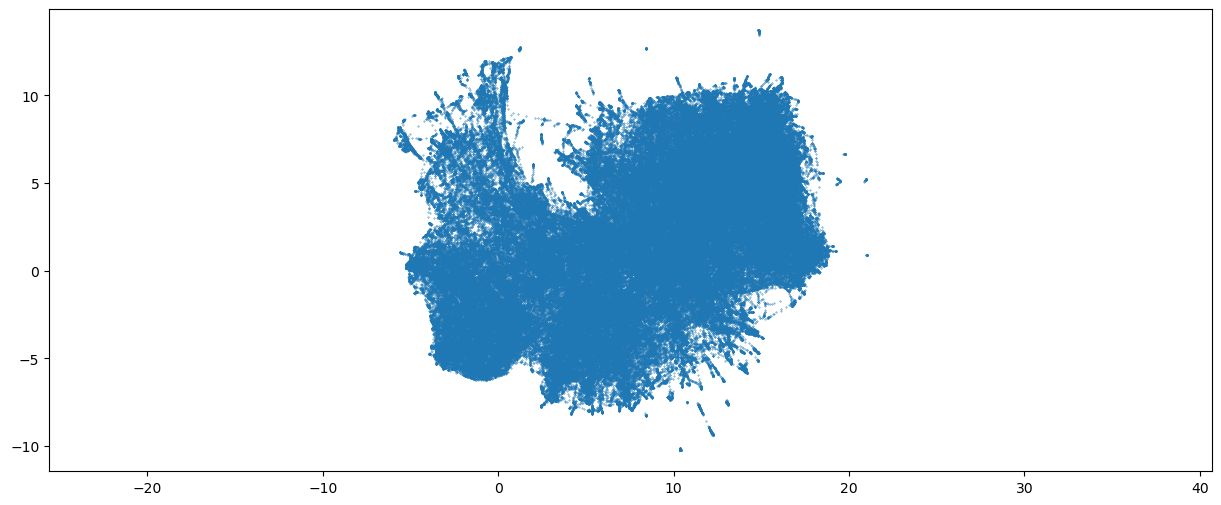

In [51]:
plt.scatter(
    exploded_columns["standard_embedding_x"],
    exploded_columns["standard_embedding_y"],
    s=0.1)
plt.gca().set_aspect('equal', 'datalim')

In [52]:
nose_to_reward_port_sum_df = pd.DataFrame(exploded_columns.groupby(["kmeans_cluster"])["nose_to_reward_port_sum"].mean())

In [53]:
nose_to_reward_port_sum_df["rank_nose_to_reward_port_sum"] = nose_to_reward_port_sum_df["nose_to_reward_port_sum"].rank().astype(int)

In [54]:
nose_to_reward_port_sum_df

,nose_to_reward_port_sum,rank_nose_to_reward_port_sum
kmeans_cluster,,
0,20.522997,5
1,5.409838,2
2,25.778363,6
3,4.040135,1
4,11.009078,3
5,26.523596,7
6,12.537311,4
7,32.54929,8


# Cluster notes

0: Not, lower half but usually not looking at the port
1: Highly Competitive, both near port and trying to actively get to port
2: Not, both upper and lower half but usually not looking at the port
3: Highly Competitive, both near port and trying to actively get to port
4: Competitive, both near port
5: Not, looking towards near upper half
6: Competitive, both near port probably moving related
7: Not, looking away near upper half

In [ ]:
cluster_to_competitiveness = {"0": "no_comp", "1": "competitive", "2": "no_comp", "3": "competitive", "4": "competitive", "5": "no_comp", "6": "competitive", "7": "no_comp"}
cluster_to_comp_id = {"0": "no_comp_5", "1": "competitive_2", "2": "no_comp_6", "3": "competitive_1", "4": "competitive_3", "5": "no_comp_7", "6": "competitive_4", "7": "no_comp_8"}
# comp_id = {"no_comp_8", "competitive_3", "competitive_1", "no_comp_6", "competitive_2", "no_comp_7", "no_comp_5", "no_comp_4"}


In [ ]:
comp_id_to_color = {'competitive_1': "#281640",
 'competitive_2': "#43246a",
 'competitive_3': "#8e7ca6",
 'no_comp_4': "#2f3600",
 'no_comp_5': "#535f00",
 'no_comp_6': "#768800",
 'no_comp_7': "#9fac4d",
 'no_comp_8': "#c8cf99"}








In [ ]:
exploded_columns["kmeans_cluster"] = exploded_columns["kmeans_cluster"].astype(str)
exploded_columns["competitiveness"] = exploded_columns["kmeans_cluster"].map(cluster_to_competitiveness)
exploded_columns["comp_id"] = exploded_columns["kmeans_cluster"].map(cluster_to_comp_id)
exploded_columns["color"] = exploded_columns["comp_id"].map(comp_id_to_color)

In [ ]:
exploded_columns["comp_id"]

## Competitive colors
Original color: 43246A
Lighter to darker (-40 0 40)

#8e7ca6
#43246a
#281640

## Not colors
Original color: 768800
Lighter to darker (30 or 60%)


#c8cf99
#9fac4d
#768800
#535f00
#2f3600

In [ ]:
from collections import OrderedDict
import matplotlib.pyplot as plt



In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
# plt.figure()

for comp_id in sorted(exploded_columns["comp_id"].unique()):
    current_df = exploded_columns[exploded_columns["comp_id"] == comp_id].copy()

    plt.scatter(
        current_df["standard_embedding_x"],
        current_df["standard_embedding_y"],
        s=0.1,
        label=" ".join(comp_id.split("_")),
        c=comp_id_to_color[comp_id])


# lgnd = plt.legend(fontsize=50)
# for handle in lgnd.legend_handles:
#     handle.set_sizes([50])

plt.xlabel("UMAP 1", fontsize=60)
plt.ylabel("UMAP 2", fontsize=60)
plt.gca().set_aspect('equal', 'datalim')
plt.title("K-means behavioral clustering", fontsize=60)
ax.tick_params(axis='both', which='major', labelsize=50)
ax.tick_params(axis='both', which='minor', labelsize=50)
# Hide top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Leave bottom and left spines
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

plt.tight_layout()
plt.savefig("./proc/kmeans_cluster_ids.png")

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
# plt.figure()

for video_id in sorted(exploded_columns["video_id"].unique()):
    current_df = exploded_columns[exploded_columns["video_id"] == video_id].copy()

    plt.scatter(
        current_df["standard_embedding_x"],
        current_df["standard_embedding_y"],
        s=0.1,
        label=video_id)


lgnd = plt.legend()
for handle in lgnd.legend_handles:
    handle.set_sizes([50])

plt.gca().set_aspect('equal', 'datalim')
plt.title("Video IDs")
plt.savefig("./proc/video_cluster_ids.png")

## Looking at metrics

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

In [ ]:
cmap = cm.viridis  # Choose a colormap

In [ ]:
features_columns

In [ ]:
# lgnd = plt.legend(fontsize=24)
# for handle in lgnd.legend_handles:
#     handle.set_sizes([50])

plt.xlabel("UMAP 1", fontsize=60)
plt.ylabel("UMAP 2", fontsize=60)
plt.gca().set_aspect('equal', 'datalim')
plt.title("K-means behavioral clustering", fontsize=60)
ax.tick_params(axis='both', which='major', labelsize=50)
ax.tick_params(axis='both', which='minor', labelsize=50)
# Hide top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Leave bottom and left spines
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

plt.tight_layout()
plt.savefig("./proc/kmeans_cluster_ids.png")

In [ ]:
features_columns

In [ ]:
current_features_columns = ["nose_to_reward_port_sum", "thorax_velocity_sum"]

In [ ]:
feat_to_title = {"nose_to_reward_port_sum": "Distances to Port", "thorax_velocity_sum": "Velocity"}
feat_to_legend = {"nose_to_reward_port_sum": "Combined distances", "thorax_velocity_sum": "Combined velocity"}

In [ ]:
for featured in current_features_columns:
    if featured == "frame_index":
        continue
    print(featured)
    fig, ax = plt.subplots(figsize=(15, 15))

    norm = Normalize(vmin=np.min(exploded_columns[featured].astype(float)), vmax=np.max(exploded_columns[featured].astype(float)))  # Normalize to the data range
    plt.scatter(
        exploded_columns["standard_embedding_x"],
        exploded_columns["standard_embedding_y"],
        c=exploded_columns[featured].astype(float),
        s=0.05, cmap = cmap, norm=norm)

    # plt.title(feat_to_title[featured], fontsize=60)
    cbar = plt.colorbar(orientation="vertical", fraction=0.026, pad=0.04).ax.tick_params(labelsize=30) 


    # plt.xlabel("UMAP 1", fontsize=60)
    # plt.ylabel("UMAP 2", fontsize=60)
    plt.gca().set_aspect('equal', 'datalim')
    ax.tick_params(axis='both', which='major', labelsize=50)
    ax.tick_params(axis='both', which='minor', labelsize=50)
    # Hide top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Leave bottom and left spines
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    plt.tight_layout()



    plt.savefig("./proc/{}_umap.png".format(featured))
    plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# The number to look for in 'group_number'
number_to_count = 1
fig, ax = plt.subplots()

for comp_id in sorted(exploded_columns["comp_id"].unique()):
    # Counting occurrences of 'number_to_count' in each 'index'
    occurrences = exploded_columns[exploded_columns['comp_id'] == comp_id]['within_trial_index'].value_counts().sort_index()
    plt.plot(occurrences.index[:599]/20, occurrences.values[:599], marker='', linestyle='-', label=comp_id, color=comp_id_to_color[comp_id], linewidth=4)

plt.axvline(x=0, color="green", label="tone start", linewidth=4)
plt.axvline(x=4, color="orange", label="reward dispensed", linewidth=4)
plt.axvline(x=10, color="red", label="tone stop", linewidth=4)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)


# plt.legend()
# Plotting
plt.title(f'Behavior cluster frequency in trials', fontsize=50)
plt.xlabel('Time from trial start(seconds)', fontsize=35)
plt.ylabel('Number of frames', fontsize=35)
plt.xlim(-10, 20)
# plt.grid(True)
plt.tight_layout()
plt.savefig("./proc/across_trial_comp.png")
plt.show()

In [ ]:
exploded_columns

In [ ]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import PolyCollection

data = [    (dt.datetime(2018, 7, 17, 0, 15), dt.datetime(2018, 7, 17, 0, 30), 'sleep'),
            (dt.datetime(2018, 7, 17, 0, 30), dt.datetime(2018, 7, 17, 0, 45), 'eat'),
            (dt.datetime(2018, 7, 17, 0, 45), dt.datetime(2018, 7, 17, 1, 0), 'work'),
            (dt.datetime(2018, 7, 17, 1, 0), dt.datetime(2018, 7, 17, 1, 30), 'sleep'),
            (dt.datetime(2018, 7, 17, 1, 15), dt.datetime(2018, 7, 17, 1, 30), 'eat'), 
            (dt.datetime(2018, 7, 17, 1, 30), dt.datetime(2018, 7, 17, 1, 45), 'work')
        ]

cats = {"sleep" : 1, "eat" : 2, "work" : 3}
colormapping = {"sleep" : "C0", "eat" : "C1", "work" : "C2"}

verts = []
colors = []
for d in data:
    v =  [(mdates.date2num(d[0]), cats[d[2]]-.4),
          (mdates.date2num(d[0]), cats[d[2]]+.4),
          (mdates.date2num(d[1]), cats[d[2]]+.4),
          (mdates.date2num(d[1]), cats[d[2]]-.4),
          (mdates.date2num(d[0]), cats[d[2]]-.4)]
    verts.append(v)
    colors.append(colormapping[d[2]])

bars = PolyCollection(verts, facecolors=colors)

fig, ax = plt.subplots()
ax.add_collection(bars)
ax.autoscale()
loc = mdates.MinuteLocator(byminute=[0,15,30,45])
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

ax.set_yticks([1,2,3])
ax.set_yticklabels(["sleep", "eat", "work"])
plt.show()

In [ ]:
raise ValueError()

In [ ]:
for featured in current_features_columns:
    if featured == "frame_index":
        continue
    print(featured)
    fig, ax = plt.subplots(figsize=(15, 15))

    norm = Normalize(vmin=np.min(exploded_columns[featured].astype(float)), vmax=np.max(exploded_columns[featured].astype(float)))  # Normalize to the data range
    plt.scatter(
        exploded_columns["standard_embedding_x"],
        exploded_columns["standard_embedding_y"],
        c=exploded_columns[featured].astype(float),
        s=0.05, cmap = cmap, norm=norm)

    # plt.title(feat_to_title[featured], fontsize=60)
    cbar = plt.colorbar(orientation="vertical", fraction=0.026, pad=0.04).ax.tick_params(labelsize=30) 


    # plt.xlabel("UMAP 1", fontsize=60)
    # plt.ylabel("UMAP 2", fontsize=60)
    plt.gca().set_aspect('equal', 'datalim')
    ax.tick_params(axis='both', which='major', labelsize=50)
    ax.tick_params(axis='both', which='minor', labelsize=50)
    # Hide top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Leave bottom and left spines
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    plt.tight_layout()



    plt.savefig("./proc/{}_umap.png".format(featured))
    plt.show()

## Grouping all the rows by video

In [ ]:
grouped_exploded_columns.columns

In [ ]:
sorted(exploded_columns.columns)

In [ ]:
to_keep_columns = [
 'tone_start_frame',
 'tone_start_timestamp',
 'tone_start_to_stop_frame',
 'tone_stop_frame',
 'tone_stop_timestamp',
 'tracked_subject',
 'video_id',
 'video_name',
 'within_trial_frame_index',
 'within_trial_index']

In [ ]:
exploded_columns

In [ ]:
export_exploded_columns.columns

In [ ]:
export_exploded_columns = export_exploded_columns.dropna(subset=["condition "])

In [ ]:
export_exploded_columns = export_exploded_columns.sort_values(by=["video_name", "current_subject", "frame_index"])

In [ ]:
export_exploded_columns["tone_start_frame"]

In [ ]:
sleap_columns

In [ ]:
# Define columns to be transformed into numpy arrays
array_columns = ['frame_index', 'tone_start_frame',
       'tone_stop_frame', 'condition ',
       'competition_closeness', 'notes', '10s_before_tone_frame',
       '10s_after_tone_frame', 'subject_thorax_to_agent_thorax',
       'nose_to_reward_port_sum', 'nose_to_reward_port_diff',
       'thorax_velocity_sum', 'thorax_velocity_diff',
       'to_reward_port_angle_sum', 'to_reward_port_angle_diff',
       'subject_nose_to_reward_port', 'subject_thorax_velocity',
       'subject_to_reward_port_angle', 'agent_nose_to_reward_port',
       'agent_thorax_velocity', 'agent_to_reward_port_angle',
       'closebool_subject_nose_to_reward_port',
       'closebool_agent_nose_to_reward_port',
       'movingbool_subject_thorax_velocity',
       'movingbool_agent_thorax_velocity', 'manual_cluster_id',
       'standard_embedding_x', 'standard_embedding_y',
       'kmeans_cluster', 'manual_cluster_id',] + sleap_columns
#'clusterable_embedding_x', 'clusterable_embedding_y', 
# Define columns to take the first value
# first_value_columns = ['session_dir', 'experiment', 'sleap_name',
#        'video_name', 'current_subject', 'video_id']

first_value_columns = ['session_dir', 'experiment', 'sleap_name',
      'video_id', "agent"]

# Define aggregation dictionary
# agg_dict = {col: lambda x: np.array(x) for col in array_columns}
agg_dict = {col: list for col in array_columns}

agg_dict.update({col: 'first' for col in first_value_columns})

# Apply groupby and aggregation
grouped_exploded_columns = export_exploded_columns.groupby(["video_name", "current_subject"]).agg(agg_dict).reset_index()


In [ ]:
grouped_exploded_columns["frame_index"] = grouped_exploded_columns["frame_index"].apply(lambda x: np.array(x).astype(int))

In [ ]:
for col in array_columns:
    grouped_exploded_columns[col] = grouped_exploded_columns[col].apply(lambda x: np.array(x))


In [ ]:
grouped_exploded_columns["video_name"].unique()

In [ ]:
grouped_exploded_columns.head()

In [ ]:
grouped_exploded_columns.to_pickle("./proc/grouped_exploded_columns.pkl")

In [ ]:
raise ValueError()